In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import numpy
from scipy.misc import logsumexp
import tqdm
import pickle
import hom2m
from galpy.util import bovy_plot, save_pickles
%pylab inline
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
numpy.random.seed(3)
import copy
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import HTML, Image
import seaborn as sns
tc= sns.color_palette('colorblind')
init_color= tc[4]
constraint_color= tc[1]
final_color= tc[3]
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Harmonic-oscillator M2M modeling of the *TGAS* F-type star data

## Observations

First we load the (a) density measurements corrected for the *TGAS* selection and (b) the measurements of $\langle v_z^2\rangle$ from the *TGAS* data alone.

Density measurements look like this:

In [16]:
# Restore the density fits to entire stellar population bins
with open('counts_vert_AthroughF_10bins_wext.sav','rb') as savefile:
    all_counts= pickle.load(savefile)
    all_counts_unc= pickle.load(savefile)
    all_effvol= pickle.load(savefile)
all_counts= all_counts[:,:,0]
all_counts_unc= all_counts_unc[:,:,0]
all_effvol= all_effvol[:,:,0]
zbins= numpy.arange(-0.4125,0.425,0.025)
ii= 1 # F stars come 2nd after A stars
c= all_counts[ii]
ec= all_counts_unc[ii]
raw= c*all_effvol[ii] # recover the raw counts
ef= all_effvol[ii]/(0.2**2.*numpy.pi*(zbins[1]-zbins[0])) # this is the effective completeness
good_dens_indx= (ef > 0.03*numpy.nanmax(ef))*(c > 0.)*((ef == ef[len(ef)//2])+(ef > 10.**-5.))*(raw > 4.)
# Load into format for HOM2M
z_obs= 0.5*(numpy.roll(zbins,-1)+zbins)[:-1]
dens_obs= c[good_dens_indx]/10.**9. # --> /pc^3
dens_obs_noise= ec[good_dens_indx]/10.**9. # --> /pc^3

<Container object of 3 artists>

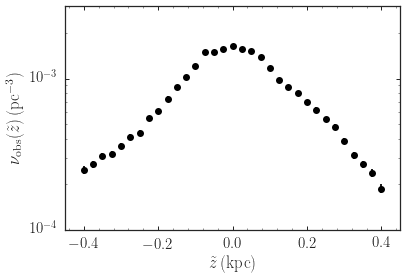

In [24]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\,(\mathrm{pc}^{-3})$',
                   xrange=[-.45,0.45],yrange=[0.0001,0.003])
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')

The $\langle v_z^2\rangle$ measurements look as follows

In [75]:
savefilename= 'Fstar-sigz.sav'
with open(savefilename,'rb') as savefile:
    out= (pickle.load(savefile),)
    while True:
        try:
            out= out+(pickle.load(savefile),)
        except EOFError:
            break
zbins,sig2z,sig2z_err,nstar,all_sam,ngauss,nboot,start= out
# Load into format for HOM2M
v2_obs= sig2z
v2_obs_noise= sig2z_err
# Setting these to NaN should be fine with the HOM2M algorithm
v2_obs[numpy.fabs(z_obs) > 0.198]= numpy.nan
v2_obs_noise[numpy.fabs(z_obs) > 0.198]= numpy.nan

<Container object of 3 artists>

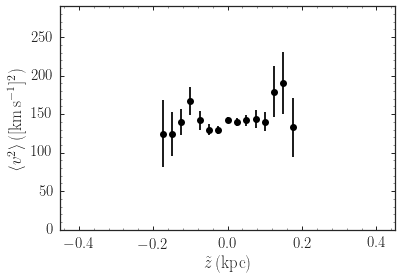

In [78]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v2_obs,'ko',
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\langle v^2\rangle\,([\mathrm{km\,s}^{-1}]^2)$',
                   xrange=[-.45,0.45],yrange=[0.0,290.],gcf=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color='k')

## Fit

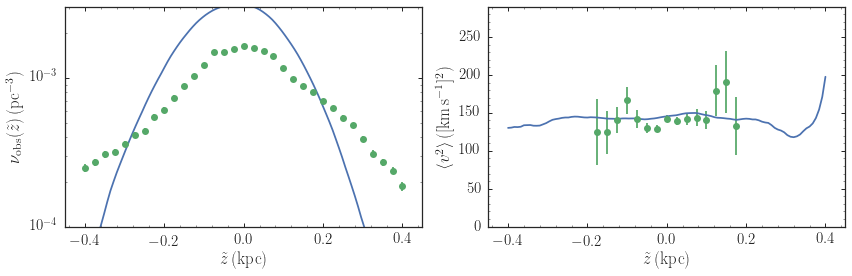

In [189]:
n_m2m= 10000
sigma_init= 12. # km/s
omega_m2m= 100. # km/s/kpc
zsun_m2m= 0.025 # pc
h_m2m= 0.075 # kpc
z_m2m, vz_m2m= hom2m.sample_iso(sigma_init,omega_m2m,n=n_m2m)
w_init= numpy.ones(n_m2m)/float(n_m2m)/1000.
z_out= numpy.linspace(-0.4,0.4,101)
dens_init= hom2m.compute_dens(z_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\,(\mathrm{pc}^{-3})$',
                   xrange=[-.45,0.45],yrange=[0.0001,0.003])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\langle v^2\rangle\,([\mathrm{km\,s}^{-1}]^2)$',
                   xrange=[-.45,0.45],yrange=[0.0,290.])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
#yscale('log',nonposy='clip')
tight_layout()

In [190]:
reload(hom2m)

<module 'hom2m' from 'hom2m.pyc'>

In [191]:
step= numpy.pi/3.*10.**-4.
nstep= 30000#0
eps= [10.**-5.5,10.**-5.,10.**2.]
smooth= None
st96smooth= False
mu= 0.
#omega_m2m= set in previous cell
fit_zsun= True
fit_omega= True
use_v2= True
skipomega= 10
delta_omega= 30.
prior= 'entropy'
w_out,zsun_out,omega_out,z_final, vz_final, Q,wevol,windx=\
        hom2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,
        z_obs,dens_obs,dens_obs_noise,
        v2_obs,v2_obs_noise,use_v2=use_v2,
        nstep=nstep,step=step,mu=mu,eps=eps,
        h_m2m=h_m2m,prior=prior,
        smooth=smooth,st96smooth=st96smooth,
        output_wevolution=10,
        fit_omega=fit_omega,skipomega=skipomega,delta_omega=delta_omega,
        fit_zsun=fit_zsun)

In [192]:
numpy.sum(w_out), numpy.sum(w_init), zsun_out[-1], omega_out[-1]

(0.00065267695724928487,
 0.0010000000000000005,
 -0.00062101044086933525,
 69.504517796742064)

('Velocity dispersions: fit', 12.445728895290312)
('omega: best-fit', 69.504517796742064)
('zsun: best-fit', -0.00062101044086933525)


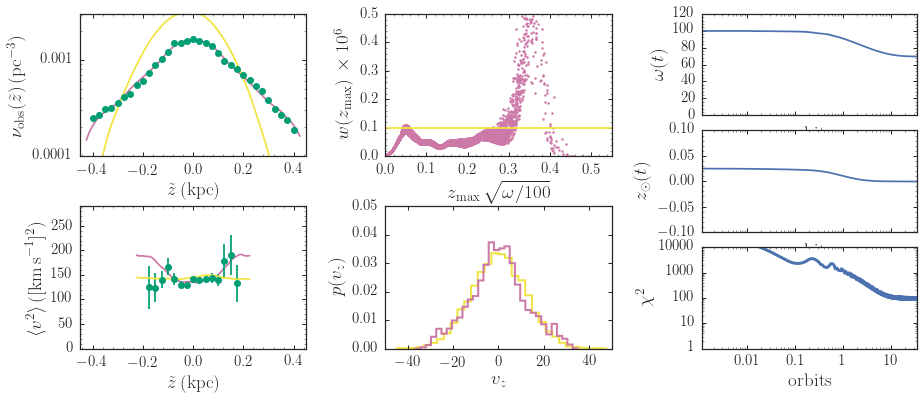

In [193]:
A_m2m, phi_m2m= hom2m.zvz_to_Aphi(z_final,vz_final,omega_out[-1])
A_init, phi_init= hom2m.zvz_to_Aphi(z_m2m,vz_m2m,omega_m2m)
z_out= numpy.linspace(-0.425,0.425,101)
dens_init= hom2m.compute_dens(z_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
z_out_v2= numpy.linspace(-0.225,0.225,101)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_m2m,z_out_v2,h_m2m,w=w_init)
dens_final= hom2m.compute_dens(z_final,zsun_out[-1],z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_final,vz_final,zsun_out[-1],z_out_v2,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
gs= gridspec.GridSpec(2,3,hspace=0.35,wspace=0.35)
gs2= gridspec.GridSpec(3,3,hspace=0.15,wspace=0.45)
subplot(gs[0])
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\,(\mathrm{pc}^{-3})$',
                   xrange=[-.45,0.45],yrange=[0.0001,0.003],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(gs[3])
bovy_plot.bovy_plot(z_out_v2,v2_init,'-',color=init_color,
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\langle v^2\rangle\,([\mathrm{km\,s}^{-1}]^2)$',
                   xrange=[-.45,0.45],yrange=[0.0,290.],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out_v2,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
subplot(gs[1])
bovy_plot.bovy_plot(A_m2m*numpy.sqrt(omega_out[-1]/100.),w_out*10.**6.,'k.',ms=5.,color=final_color,
                    xlabel=r'$z_{\mathrm{max}}\,\sqrt{\omega/100}$',
                    ylabel=r'$w(z_{\mathrm{max}})\,\times 10^6$',
                   yrange=[0.,5.*w_init[0]*10.**6.],xrange=[0.,0.55],gcf=True)
axhline(w_init[0]*10.**6.,color=init_color,)
subplot(gs[4])
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
_= hist(vz_final,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(-50.,50.)
ylim(0.,0.05)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: fit",\
      numpy.sqrt(numpy.sum(w_out*(vz_final-numpy.sum(w_out*vz_final)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(gs2[0,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*numpy.median(omega_out)/2./numpy.pi,omega_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,120.],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\omega(t)$',gcf=True)
print("omega: best-fit",omega_out[-1])
#gca().xaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs2[1,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*numpy.median(omega_out)/2./numpy.pi,zsun_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[-0.1,0.1],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$z_\odot(t)$',gcf=True)
print("zsun: best-fit",zsun_out[-1])
#gca().xaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs2[2,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*numpy.median(omega_out)/2./numpy.pi,
                    numpy.nansum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**4.])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))